In [101]:
import torch
from torchvision import datasets,transforms
from skimage.feature import local_binary_pattern,hog
import matplotlib.pyplot as plt
from skimage import color
import numpy as np
from sklearn.svm import SVC
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import cv2

In [102]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./../datasets', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./../datasets', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

images, labels = next(iter(trainloader))

In [103]:
images = images.permute(0, 2, 3, 1).numpy()  # Convert to (N, H, W, C)
labels = np.array(labels)  # Convert to NumPy array

def preprocess_image(image):
    gray_img = color.rgb2gray(image)  # Convert to grayscale
    gray_img = cv2.resize(gray_img, (64, 64))  # Resize for consistency
    return gray_img

# LBP Feature Extraction Function
def extract_lbp_features(image, radius=3, n_bins=20):
    gray = preprocess_image(image)  # Preprocess image
    lbp = local_binary_pattern(gray, P=8*radius, R=radius, method="uniform")  # Compute LBP
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))  # LBP histogram
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize
    return hist

# Extract LBP features for 100 images
X_features = np.array([extract_lbp_features(img) for img in images])
y_labels = labels

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(X_features))
X_train, X_test = X_features[:train_size], X_features[train_size:]
y_train, y_test = y_labels[:train_size], y_labels[train_size:]

In [104]:
# Train SVM classifier
svm = SVC(kernel='rbf', C=90.0)  # Linear SVM
svm.fit(X_train, y_train)

# Make predictions
y_pred = svm.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred, target_names=trainset.classes))

Accuracy: 21.50%
              precision    recall  f1-score   support

    airplane       0.31      0.33      0.32        24
  automobile       0.22      0.40      0.29        15
        bird       0.10      0.08      0.09        25
         cat       0.05      0.07      0.06        14
        deer       0.16      0.22      0.19        18
         dog       0.12      0.11      0.11        19
        frog       0.36      0.19      0.25        21
       horse       0.27      0.19      0.22        21
        ship       0.26      0.24      0.25        25
       truck       0.40      0.33      0.36        18

    accuracy                           0.21       200
   macro avg       0.23      0.22      0.21       200
weighted avg       0.23      0.21      0.22       200



In [105]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Try different values of k
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")
# Detailed classification report
print("KNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Accuracy: 19.00%
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.15      0.25      0.19        24
           1       0.14      0.27      0.19        15
           2       0.20      0.16      0.18        25
           3       0.08      0.07      0.08        14
           4       0.19      0.22      0.21        18
           5       0.20      0.16      0.18        19
           6       0.46      0.29      0.35        21
           7       0.16      0.14      0.15        21
           8       0.17      0.16      0.17        25
           9       0.30      0.17      0.21        18

    accuracy                           0.19       200
   macro avg       0.21      0.19      0.19       200
weighted avg       0.21      0.19      0.19       200



/home/vinoth/.local/lib/python3.10/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


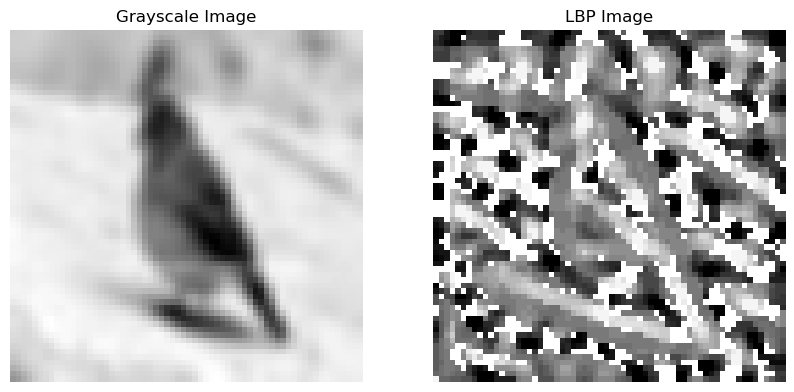

Extracted LBP Features: [0.07323658 0.02058724 0.03037462 0.03476207 0.03509956 0.04522443
 0.05264934 0.04151198 0.0323996  0.03746203 0.04556193 0.07728653
 0.10529868 0.09483631 0.0560243  0.04623692 0.03408707 0.03712454
 0.03678704 0.06344921]


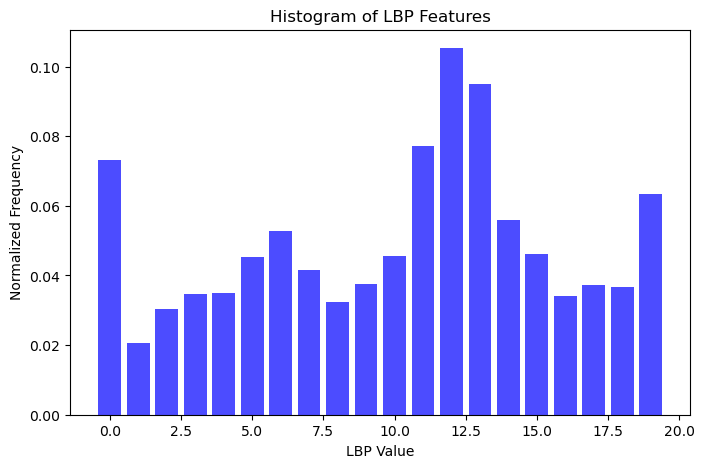

In [106]:
# For 1 Image
# LBP parameters
i = random.randint(1,100)
radius = 3  # Neighborhood radius
n_points = 8 * radius  # Number of points in the neighborhood

# Compute LBP features
def extract_lbp_features(image):
    lbp = local_binary_pattern(image, P=n_points, R=radius, method="uniform")
    return lbp

# Load an image (Assuming it's a NumPy array)
image = images[i]
# image = image.permute(1, 2, 0)

# Preprocess and extract LBP
gray_image = preprocess_image(image)
lbp_image = extract_lbp_features(gray_image)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title("Grayscale Image")
axes[0].axis("off")

axes[1].imshow(lbp_image, cmap='gray')
axes[1].set_title("LBP Image")
axes[1].axis("off")

plt.show()

# Convert LBP to feature histogram
def lbp_histogram(lbp_image, n_bins=20):
    hist, _ = np.histogram(lbp_image.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize histogram
    return hist

lbp_features = lbp_histogram(lbp_image)
print("Extracted LBP Features:", lbp_features)

# Plot LBP histogram
def plot_lbp_histogram(lbp_features, n_bins=20):
    plt.figure(figsize=(8, 5))
    plt.bar(range(n_bins), lbp_features, color='blue', alpha=0.7)
    plt.xlabel("LBP Value")
    plt.ylabel("Normalized Frequency")
    plt.title("Histogram of LBP Features")
    plt.show()

# Compute and plot LBP histogram
lbp_features = lbp_histogram(lbp_image)
plot_lbp_histogram(lbp_features)